In [1]:
## Used to create clusters of the vectorized data. Currently using good old k-means
## to visualize, we projected the data on 2d using PCA
## (taken from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)
## as the PCA decomposition showed dominance of Gender and Race, we took them out of the game before clustering 

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.externals import joblib


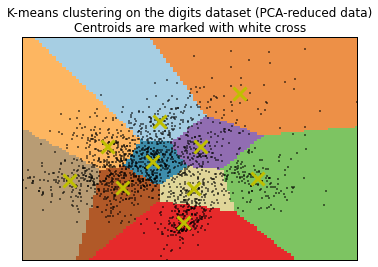

In [3]:

###############################################################################
# Visualize results on PCA-reduced data
def visualize_kmeans(kmeans, data, resolution = 100):
    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans.fit(reduced_data)

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
    y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='y', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

digits = load_digits()
dig_data = scale(digits.data)

n_samples, n_features = dig_data.shape
n_digits = len(np.unique(digits.target))

visualize_kmeans(KMeans(init='k-means++', n_clusters=10, n_init=10), dig_data)


In [4]:
proact_train = pd.read_csv('../train_data_vectorized.csv', sep = '|', error_bad_lines=False, index_col='SubjectID', dtype='float')
proact_train.head(3)


,bp_diastolic,bp_systolic,height,pulse,respiratory_rate,temperature,weight,F,Asian,Black,Hispanic,Other,White
SubjectID,,,,,,,,,,,,,
100256,-0.516411,-0.340148,0.00025,0.440030,0.009804,0.037261,-0.141928,0,0,0,0,0,1
100626,-0.136655,-0.347385,0.00025,0.007043,0.064004,-0.000389,0.011066,0,0,0,0,0,1
100806,0.436971,0.236458,0.00025,-0.292272,0.005522,-0.000389,0.043708,0,0,0,0,0,1


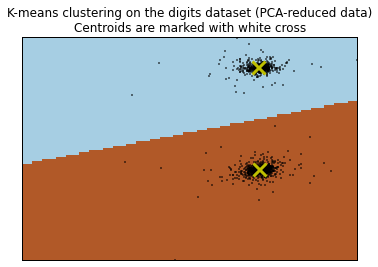

[(-0.0012087102659833844, 'respiratory_rate'),
 (-0.00062210902321028312, 'height'),
 (-0.00060920276060424385, 'temperature'),
 (-0.00041961497473864132, 'Asian'),
 (-0.00041075292857822588, 'White'),
 (-0.00035887546133956988, 'Black'),
 (-0.00030317404714478473, 'Hispanic'),
 (-0.00027902943928527225, 'bp_systolic'),
 (0.0002442678681520335, 'pulse'),
 (0.0004876248892642886, 'bp_diastolic'),
 (0.00065703629680486102, 'Other'),
 (0.00066814654142820034, 'weight'),
 (1.0, 'F')]

In [5]:
kmeans = KMeans(init='k-means++', n_clusters=2)
visualize_kmeans(kmeans, proact_train)
kmeans.fit(proact_train)
sorted([(metrics.adjusted_mutual_info_score(proact_train[col], kmeans.labels_), col) for col in proact_train.columns])

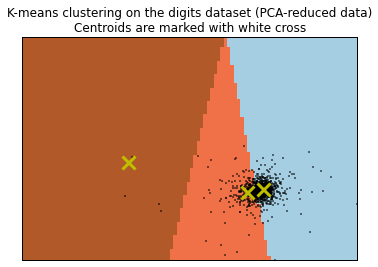

[(-0.00099260633853862881, 'F'),
 (-0.00060717978604978343, 'height'),
 (-0.0001755560547334332, 'Hispanic'),
 (-0.00011347213438569435, 'respiratory_rate'),
 (-9.2768440631806396e-05, 'White'),
 (0.00027136241246723743, 'Other'),
 (0.00065838740175251252, 'Asian'),
 (0.0011516338936328871, 'Black'),
 (0.002381661332362851, 'weight'),
 (0.0062352750627999616, 'pulse'),
 (0.01046257352923911, 'bp_diastolic'),
 (0.011290798622886389, 'temperature'),
 (0.012374153148575059, 'bp_systolic')]

In [6]:
proact_train_no_dominants = proact_train.drop(['F', 'White'], 1)
kmeans = KMeans(init='k-means++', n_clusters=3)
visualize_kmeans(kmeans, proact_train_no_dominants)
kmeans.fit(proact_train_no_dominants)
sorted([(metrics.adjusted_mutual_info_score(proact_train[col], kmeans.labels_), col) for col in proact_train.columns])

In [7]:
for t in ['train', 'test']:
    cur_data = pd.read_csv('../' + t + '_data_vectorized.csv', sep = '|', error_bad_lines=False, index_col='SubjectID')
    data_no_dominants = cur_data.drop(['F', 'White'], 1)
    res = pd.DataFrame(index = data_no_dominants.index)
    res['cluster'] = kmeans.predict(data_no_dominants)
    res.to_csv('../' + t + '_kmeans_clusters.csv',sep='|')